# Introduction to FlipPy

<div align="center">
    <img src="https://raw.githubusercontent.com/codec-lab/flippy/refs/heads/main/flippy-wide.svg" alt="FlipPy Logo" width="40%"/>
</div>

[FlipPy](https://codec-lab.github.io/flippy/) is a lightweight probabilistic programming language 
that is written entirely in Python. It prioritizes integration with Python, universality, 
and user-friendliness. It takes inspiration from the design and implementation
of [WebPPL](http://webppl.org/). 

In a nutshell, FlipPy is a library for expressing **probabilistic models** 
as Python programs and performing **probabilistic inference** over those models.
Here, we briefly discuss how FlipPy extends Python from a deterministic programming language
to a probabilistic programming language before elaborating on the FlipPy API.

This tutorial assumes basic familiarity with Python as well as probability theory.

The following additional tutorials are also available:

- [Rational Speech Acts (RSA)](./01-RSA)
- [Language of Thought (LoT)](./02-LoT)
- [Hidden Markov Models (HMMs)](./03-HMMs)
- [Bayesian Non-parametrics](./04-DP-MM)
- [Intuitive Physics](./05-Physics)
- [Sequential Decision-Making](./06-Sequential-DM)

# From deterministic to probabilistic Python

Like most general-purpose programming languages, Python is not inherently probabilistic.
For instance, below we have a simple deterministic function that assigns 
values to variables `x` and `y`:

In [2]:
def deterministic_fn():
    x = 1
    y = 0
    return x + y

deterministic_fn() # Always returns 1

1

Every time you run `deterministic_fn`, you get the same answer.

Alternatively, we could add randomness to a function by *probabilistically* assigning values
to `x` and `y`. For example, in the next cell, we randomly assign values to `x` and `y`
by using a function from FlipPy called `flip(p)` that returns 1 with probability `p`
and 0 with probability `1 - p`.

In [3]:
from flippy import flip

def probabilistic_fn():
    x = flip(.4) # assigns 0 or 1
    y = flip(.7) # assigns 0 or 1
    return x + y

probabilistic_fn() # returns 0, 1, or 2

1

Every time you run `probabilistic_fn`, you get one of three possible values:
`0`, `1`, or `2` depending on what each call to `flip()` assigns to `x` or `y`.
Try running the above cell multiple times to check this.

Note that `probablistic_fn` **implicitly** defines a distribution over possible return 
values (`0`, `1`, and `2`). What if we wanted to **explicitly** represent those probabiliites?
That is, what if I wanted to know the numerical probability of returning each value? FlipPy
has a special function called `infer` that converts functions like `probabilistic_fn`
with implicit randomness into functions that return **explicit distributions**<sup>[1](#reify)</sup>. 
The next few cells show how this works.

<hr>

<a name="reify">1</a>: This is sometimes called "reifying" a random function into a distribution.

In [4]:
from flippy import flip, infer

def implicit_probabilistic_fn():
    x = flip(.4)
    y = flip(.7)
    return x + y

explicit_probabilistic_fn = infer(implicit_probabilistic_fn)

In [5]:
# each time you run this you get 0, 1, or 2 with some probability
implicit_probabilistic_fn() 

2

In [6]:
# each time you run this you get a distribution object
# with numerical probabilities for 0, 1, and 2
dist = explicit_probabilistic_fn() 
dist

,Element,Probability
0,1,0.540
1,0,0.180
2,2,0.280


Note that even though the `dist` object returned by `explicit_probabilistic_fn()` is
rendered in the Jupyter notebook as a table, it is in fact an instance of a FlipPy
`Distribution` class or one of its subclasses.

In [7]:
from flippy.distributions import Distribution
print(dist)
print(isinstance(dist, Distribution))

DiscreteInferenceResult(support=(1, 0, 2), probabilities=(np.float64(0.54), np.float64(0.18000000000000005), np.float64(0.27999999999999997)))
True


These distribution classes have a number of useful helper methods.

In [8]:
# Distributions can be sampled from
dist.sample()

1

In [9]:
# We can get probabilities and log-probabliites of values
print(dist.prob(2))
print(dist.prob(3))
print(dist.log_probability(1))

0.27999999999999997
0.0
-0.616186139423817


In [10]:
# Distributions can be converted to dictionaries (as long as they are finite)
dict(dist)

{1: 0.54, 0: 0.18000000000000005, 2: 0.27999999999999997}

Distributions can also be sampled from **within** an `infer`-ed 
function to create new functions. For example, 

In [11]:
@infer # Note that here we use infer as a function decorator
def another_probabilistic_fn():
    a = dist.sample()
    b = dist.sample()
    return a + b

another_probabilistic_fn()

,Element,Probability
0,2,0.392
1,1,0.194
2,3,0.302
3,4,0.078
4,0,0.032


FlipPy includes a number of elementary distributions that can be imported 
from `flippy.distributions`, as in the following cell.

In [12]:
from flippy.distributions import Normal, Uniform, Beta, Bernoulli, Binomial, \
    Geometric, Poisson, Dirichlet, Multinomial

my_beta = Beta(2, 5)
my_beta.sample()

0.13396729752285014

# Bayesian inference with FlipPy

In the previous section, we used FlipPy to turn implicit
randomness into explicit distributions, but these were all in cases where
we were only performing **forward simulation** of a generative model. In **Bayesian inference**,
we typically treat such models as data-generating processes, and then 
condition on observed data to get **posterior distributions** over variables
involved in that process. This idea captured succinctly by Bayes rule:

$$
P(\text{model} \mid \text{data}) \propto P(\text{data} \mid \text{model}) P(\text{model})
$$

To make things more concrete, consider a generative model in which we first
randomly choose between a fair coin and a biased coin, flip it 10 times, and
add up the number of heads. We can write this process out as the following function:

<Axes: ylabel='Probability'>

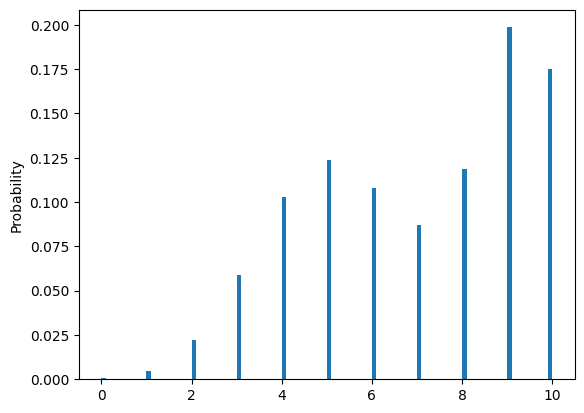

In [13]:
@infer
def coin_flipping_model():
    # randomly choose a fair coin or biased coin
    # note that `coin` is going to be a function
    coin_type = 'fair' if flip() else 'biased'
    if coin_type == 'fair':
        coin = lambda : flip(.5) # fair coin
    else:
        coin = lambda : flip(.9) # biased coin

    # simulate flipping the coin 10 times
    heads_simulated = 0
    for _ in range(10):
        heads_simulated += coin()
    
    return heads_simulated

coin_flipping_model().plot()

Now suppose that you don't know which coin was chosen
but you observed 9 heads out of 10 flips. Which coin would you think was chosen?
What if you observed 3 heads? 7 heads?

In FlipPy, we can express this logic of **conditioning** inferences
on observed data by using `condition` statements. The following cell
rewrites the coin flipping model to capture this logic.

In [14]:
from flippy import condition

@infer
def coin_flipping_model_with_observations(heads_observed):
    # randomly choose a fair coin or biased coin
    # note that `coin` is going to be a function
    coin_type = 'fair' if flip() else 'biased'
    if coin_type == 'fair':
        coin = lambda : flip(.5) # fair coin
    else:
        coin = lambda : flip(.9) # biased coin

    # simulate flipping the coin 10 times
    heads_simulated = 0
    for _ in range(10):
        heads_simulated += coin()

    # NEW! condition on simulated heads being the same as observed heads
    condition(heads_observed == heads_simulated)

    return coin_type # return string not function

coin_flipping_model_with_observations(9)

,Element,Probability
0,biased,0.975
1,fair,0.025


In the last line, we called `coin_flipping_model_with_observations` with
9 of 10 heads observed, and it told us that the coin was much more likely to be
biased than to be fair. That makes sense!

Lets unpack what's happening here. 

When we call the `infer`-ed `coin_flipping_model_with_observations` with the number of observed
heads, we are essentially simulating flipping the fair or biased coin, conditioning
on the observed heads matching the simulated heads, and then returning
the `coin_type`. You can think of `condition` as telling `infer` whether or not
a simulation is consistent with a condition. Here, that condition
is whether the number of simulated heads equals the number of observed heads.


In the next cell, we run `coin_flipping_model_with_observations` for different
numbers of heads observed and plot the results using seaborn. As you can see,
the more heads you observe, the more you believe the coin is biased, which makes sense!

**Test your understanding**: Why are we returning `coin_type` and not `heads_simulated`,
as in our original `coin_flipping_model` implementation? 

**Note**: `condition` can take any non-negative value, but in this example
we only pass in boolean values. Remember that in Python, booleans subclass integers
(`1 == True`, `0 == False`).

<Axes: xlabel='heads_observed', ylabel='prob'>

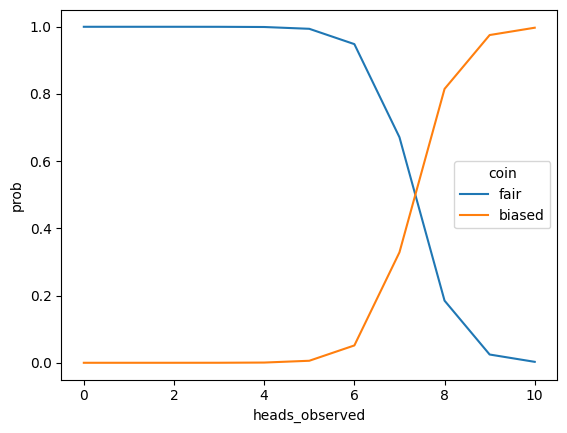

In [15]:
import seaborn as sns
import pandas as pd

coin_posteriors = []
for heads_observed in range(0, 11):
    res = coin_flipping_model_with_observations(heads_observed)
    coin_posteriors.append({'prob': res.prob('fair'), 'coin': 'fair', 'heads_observed': heads_observed})
    coin_posteriors.append({'prob': res.prob('biased'), 'coin': 'biased', 'heads_observed': heads_observed})

coin_posteriors = pd.DataFrame(coin_posteriors)
sns.lineplot(data=coin_posteriors, x='heads_observed', y='prob', hue='coin')


## Alternative ways to condition in FlipPy

In the previous examples, we used `condition` with a boolean input to influence
the posterior distribution of each program. FlipPy provides several other ways
to perform conditioning. 

For example, `factor` statements
operate similarly to `condition` statements but are in log-space.
This interface is useful for specifying utilities similar to the 
implementation of `factor` in [WebPPL](http://webppl.org/) (see other tutorial notebooks for examples).

Additionally, each `Distribution`
object has an `.observe(x)` method that corresponds to conditioning by "observing"
a value from a distribution. 
This interface is useful when it is more convenient to specify 
conditioning in terms of the likelihood of a distribution as described in
[van de Meent et al. (2018)](https://arxiv.org/abs/1809.10756).

The next few cells demonstrate these three equivalent ways of conditioning.

In [16]:
from flippy import condition, factor
import math

@infer
def condition_model():
    x = flip()
    y = flip()
    condition(.9 if x == y else .1) # note here we pass condition a "soft constraint"
    return x + y

condition_model()

,Element,Probability
0,2,0.450
1,1,0.100
2,0,0.450


In [17]:
@infer
def factor_model():
    x = flip()
    y = flip()
    factor(math.log(.9) if x == y else math.log(.1)) # note we convert to log-space
    return x + y

factor_model()

,Element,Probability
0,2,0.450
1,1,0.100
2,0,0.450


In [18]:
@infer
def observe_model():
    x = flip()
    y = flip()
    Bernoulli(.9).observe(x == y)
    return x + y

observe_model()

,Element,Probability
0,2,0.450
1,1,0.100
2,0,0.450


# More complex models and inference in FlipPy

The first part of this notebook outlined the basic approach to probabilistic
programming in FlipPy: 

1. Specify a generative process as a random program by sampling from distributions,
2. Condition on certain properties of that process, and 
3. Perform inference to obtain a posterior distribution over return values.

We focused on doing exact inference with
simple coin flipping models, but FlipPy supports specification of models
that include more complex components 
(e.g., continuous distributions, recursion, stochastic memoization)
and provides several algorithms for doing approximate inference in such models
(e.g., likelihood weighting, Markov Chain Monte Carlo). The next few cells provide
examples, as do the other notebooks included in the tutorial.

### Medical Diagnosis

In [19]:
@infer
def model():
    smokes = flip(.2)
    lungDisease = flip(0.001) or (smokes and flip(0.1))
    cold = flip(0.02)

    cough = (cold and flip(0.5)) or (lungDisease and flip(0.5)) or flip(0.001)
    fever = (cold and flip(0.3)) or flip(0.01)
    chestPain = (lungDisease and flip(0.2)) or flip(0.01)
    shortnessOfBreath = (lungDisease and flip(0.2)) or flip(0.01)

    condition(cough and chestPain and shortnessOfBreath and not fever)

    return {'smokes': smokes}

model()

smokes,Probability
True,0.961
False,0.039


### Stochastic memoization

In deterministic programs, function calls can be "memoized" or "cached" by 
saving the return values associated with a set of function arguments for later
reuse. In probablistic programs, we can perform an analogous operation 
called **stochastic memoization**, in which function calls are saved and reused
*within a random execution*. This allows us to flexibly specify more expressive models
that involve shared structure. 

In FlipPy, stochastic memoization is implemented 
with the `mem` function. The following example from 
[Goodman, Tenenbaum & Gerstenberg (2014)](https://cocolab.stanford.edu/papers/GoodmanEtAl2015-Chapter.pdf)
demonstrates this.

In [20]:
from flippy import mem
from flippy.distributions import Gaussian

@mem
def strength(player):
    return Gaussian(0, 1).sample()

@mem
def lazy(player, game):
    return flip(.1)

@mem
def team_strength(team, game):
    return sum([
        strength(p)/2 
        if lazy(p, game) 
        else strength(p) 
        for p in team
    ])

@mem
def winner(team1, team2, game):
    if team_strength(team1, game) > team_strength(team2, game):
        return 'team1'
    return 'team2'

@infer(method="LikelihoodWeighting", samples=1000, seed=129299)
def model():
    winning_teams = [
        winner(team1=("TG",), team2=("NG",), game=1),
        winner(team1=("NG",), team2=("AS",), game=2),
        winner(team1=("NG",), team2=("BL",), game=3)
    ]
    condition(
        winning_teams[0] == 'team1' and
        winning_teams[1] == 'team1' and
        winning_teams[2] == 'team1'
    )
    return {"TG": strength("TG"), "NG": strength("NG"), "AS": strength("AS"), "BL": strength("BL")}

res = model()

In [21]:
# How strong is each player expected to be?

# `res` is a joint distribution over player strengths
# represented as a distribution over dictionaries

# Here, we use marginalization to get the distribution over each player's strength
# and then print the expected value of the marginalized distribution
for player in ['TG', 'BL', 'NG', 'AS']:
    marginal_dist = res.marginalize(lambda x: x[player])
    expected_strength = marginal_dist.expected_value()
    print(f"Expected strength of {player}: {expected_strength:.2f}")

Expected strength of TG: 1.00
Expected strength of BL: -0.63
Expected strength of NG: 0.32
Expected strength of AS: -0.62


### Recursive distributions

(0.0, 100.0)

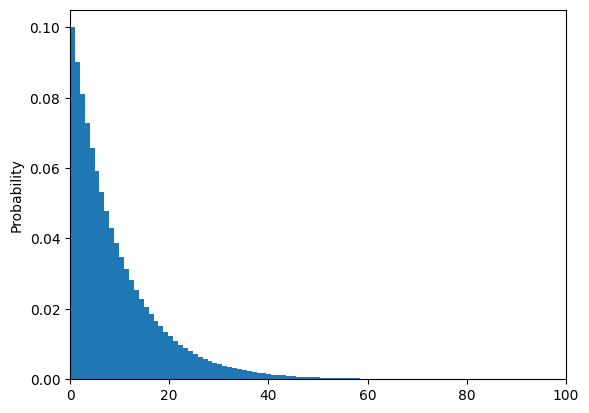

In [22]:
# note we need to bound the number of states to avoid infinite recursion
@infer(max_states=100)
def geometric_model(p):
    def geometric():
        if flip(p):
            return 1 + geometric()
        return 0
    return geometric()
ax = geometric_model(.9).plot()
ax.set_xlim(0, 100)

(0.0, 100.0)

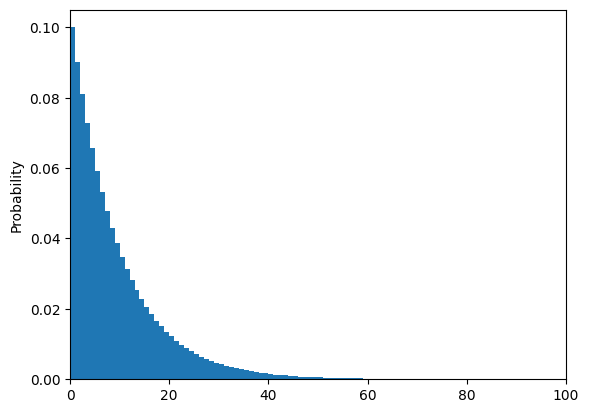

In [23]:
# alternatively, we can use a truncated geometric model
@infer
def truncated_geometric_model(p, n):
    def geometric(n):
        condition(n >= 0) # this line truncates the recursion 
        if flip(p):
            return 1 + geometric(n - 1)
        return 0
    return geometric(n)
ax = truncated_geometric_model(.9, 100).plot()
ax.set_xlim(0, 100)

(0.0, 100.0)

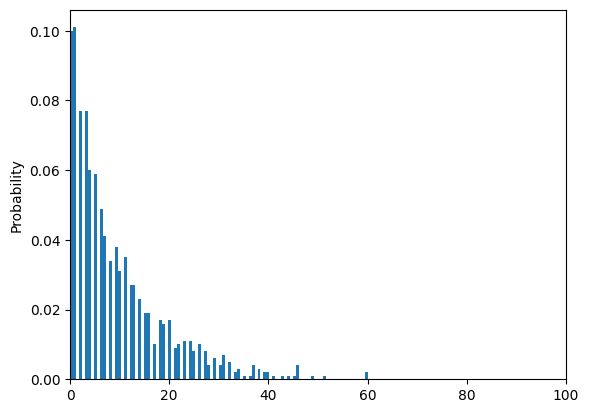

In [24]:
# or, we can use an approximate inference method that does not enumerate all states
@infer(method="LikelihoodWeighting", samples=1000, seed=42)
def approx_geometric_model(p):
    def geometric():
        # note we do not need to truncate since we're sampling
        if flip(p):
            return 1 + geometric()
        return 0
    return geometric()
ax = approx_geometric_model(.9).plot()
ax.set_xlim(0, 100)

### Continuous Distributions

Analytic posterior mean and std: -0.67, 0.30
Empirical posterior mean and std: -0.68, 0.31


<Axes: ylabel='Probability'>

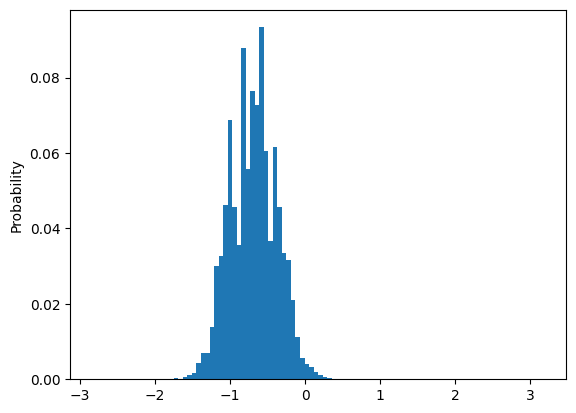

In [25]:
from flippy.distributions import Normal, NormalNormal

@infer(
    method="LikelihoodWeighting",
    samples=1000,
    seed=1234
)
def normal_model(obs, hyper_mu, hyper_sigma, sigma):
    mu = Normal(hyper_mu, hyper_sigma).sample()
    [Normal(mu, sigma).observe(o) for o in obs]
    return mu

obs = (-.75, -.72, -.57, -.82, -.69, -.77, -.74, -.76, -.8, -.79)
res = normal_model(obs, hyper_mu=0, hyper_sigma=1, sigma=1)

# we can compare to the mean and standard deviation of the analytical solution
analytic = NormalNormal(prior_mean=0, prior_sd=1, sd=1).update(obs)
print(f"Analytic posterior mean and std: {analytic.prior_mean:.2f}, {analytic.prior_sd:.2f}" )

empirical_mean = res.expected_value()
empirical_sd = res.expected_value(lambda x: (x - empirical_mean) ** 2) ** 0.5
print(f"Empirical posterior mean and std: {empirical_mean:.2f}, {empirical_sd:.2f}" )

res.plot()

In [26]:
from flippy.distributions import Uniform

@infer(
    method="MetropolisHastings",
    samples=500,
    burn_in=500,
    thinning=10,
    seed=100
)
def mixture_model(data):
    p = Uniform(0, 1).sample()
    mu1 = Normal(0, 5).sample()
    mu2 = Normal(0, 5).sample()
    cluster = [flip(p) for _ in data]
    for i in range(len(data)):
        if cluster[i]:
            Normal(mu1, 1).observe(data[i])
        else:
            Normal(mu2, 1).observe(data[i])
    return dict(p=p, mu1=mu1, mu2=mu2)

<Axes: ylabel='Probability'>

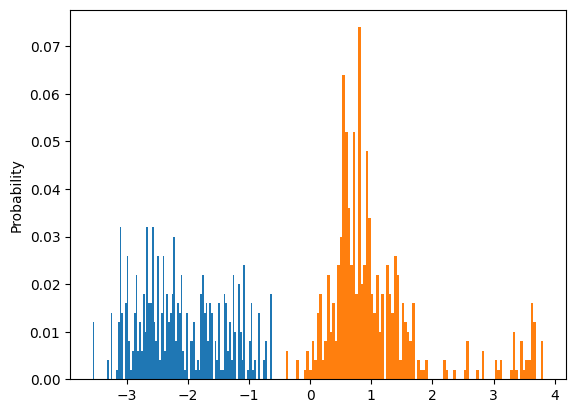

In [27]:
import matplotlib.pyplot as plt

data = (
    -3.39, -0.74, -1.74, -3.84, -1.87,  # cluster 1; mu1 = -2, sigma1 = 1
    0.12, 1.18, -0.32, 1.3, 2.26 # cluster 2; mu2 = 1, sigma2 = 1
)
res = mixture_model(data)

fig, ax = plt.subplots()
res.marginalize(lambda x: x["mu1"]).plot(ax)
res.marginalize(lambda x: x["mu2"]).plot(ax)

# Python and FlipPy

One of the design goals of FlipPy is seamless integration with the rest of Python.

To this end, FlipPy includes a `keep_deterministic` function that makes it possible to use
arbitrary deterministic Python for simulation and inference. For instance, 
one could perform inference with a physics simulator using the following recipe:
```python
from flippy import keep_deterministic, infer, condition

@keep_deterministic
def run_simulation(params):
    return external_physics_library(params)

@infer
def model(observed_result):
    params = params_prior()
    result = run_simulation(params)
    condition(result == observed_result)
    return params
```


Additionally, FlipPy supports a functional subset of Python syntax as well as
some imperative constructs (e.g., "safe" variable reassignment, well-behaved loops). 
The list below summarizes the Python constructs that FlipPy currently does and does not support:

### Supported syntax
- Variable assignment
    ```python
    x = flip()
    ```
- Variable re-assignment (Note that there are some restrictions on reassignment 
when variables are used across multiple function scopes).
    ```python
    x = flip()
    x = 2
    ```
- Augmented assignment
    ```python
    x += 1
    ```
- Branching
    ```python
    test = flip() + flip()
    if test == 0:
        x = 2
    elif test == 1:
        x = 3
    else:
        x = 4
    ```
- Ternary operator (i.e., if-then-else)
    ```python
    value if test else other_value
    ```
- Function declaration 
    ```python
    def func(p, x=10):
        return flip(p)*x
    ```
- Lambda functions
    ```python
    lambda i : i + flip()
    ```
- Attribute lookups
    ```python
    my_obj.attribute
    ```
- list/set/dict comprehensions
    ```python
    [dist.observe(datum) for datum in data]
    ```
- Finite `for` loops
    ```python
    total = 0
    for _ in range(10): 
        total += flip()
    ```
- `while` loops:
    ```python
    total = 0
    while True:
        if flip(.05):
            break
        total += flip()
    ```
- `break`, `continue`, `return` from a loop
- Function decorators
    ```python
    @decorator
    def myfunc(i):
        return flip()
    ```
- Short circuiting of logical operators
    ```python
    if True or flip(): # flip() will never be called
        do something
    ```
- Asserts
    ```python
    assert 0 < p <= 1
    x = flip(p)
    ```
- Exceptions
    ```python
    if p > 1:
        raise Exception("p is greater than 1")
    ```
- Side effects (also see `keep_deterministic`)
    ```python
    @infer
    def f()
        print('hello from inside a function!')
        return flip()
    ```

### Unsupported syntax
- In-place mutation
    ```python
    x[i] = 2
    ```
- Global, nonlocal variables
    ```python
    global x
    nonlocal x
    ```
- Class definitions
    ```python
    class MyClass:
        ...
    ```
- `async`
- `with`
- `match`
- `try ... except ... finally`
- `import ...`
- `await ...`
- `yield ...`
- Assignment within expression, e.g. `x := 10`
- Named expressions, e.g., `[y := 1, y**2, y**3]`

Happy flipping! 🐬